In [1]:
# First Step is to obtain the data from the census website
# After some research concluded that B08303 is the correct data set to use (it is titled "Travel Time to Work"
# The basis for using this dataset is the obvious inverse relationship between Telework and Commute Times

In [3]:
# We begin with the 2023 and 2022 "ACS 1-Year Estimates Detailed Tables".
# The weblinks are: https://data.census.gov/table/ACSDT1Y2023.B08303?g=010XX00US$3300000 for 2023
# The link is the census website (data.census.gov), "Table" because we want the option to download
# ACSDT1, I have learned, stands for American Community Survey (ACS) Detailed Tables - perhaps data tables - for 1 year
#  The last 5 year was issued in 2022 so the most recent data in 2023 is single year
# B08303 refers to the "Travel to Work Data" which for historic reasons is known as B08303
# This was then set up by geography - hence the "g=", and then the 010 is a placeholder, and XX00US is a placeholder for all States
#  33000000 appears to be by metropolitan area

In [5]:
# The given the small number of files we need to download this can be done manually
# But to show that it CAN be done automatically used Claude to create some code which will use an API (secret under env)
# to download data for each year and then to create csv files with that data

In [9]:
import os
import time
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np
from requests.exceptions import RequestException

# Load environment variables from the specific .env file
load_dotenv('CENSUS_API_KEY.env')

# Get API key from environment variable
api_key = os.getenv('CENSUS_API_KEY')

# Define human-readable column names
column_names = {
    'NAME': 'Metro Area',
    'B08303_001E': 'Total',
    'B08303_002E': 'Less than 5 minutes',
    'B08303_003E': '5 to 9 minutes',
    'B08303_004E': '10 to 14 minutes',
    'B08303_005E': '15 to 19 minutes',
    'B08303_006E': '20 to 24 minutes',
    'B08303_007E': '25 to 29 minutes',
    'B08303_008E': '30 to 34 minutes',
    'B08303_009E': '35 to 39 minutes',
    'B08303_010E': '40 to 44 minutes',
    'B08303_011E': '45 to 59 minutes',
    'B08303_012E': '60 to 89 minutes',
    'B08303_013E': '90 or more minutes'
}

def fetch_and_save_data(year, max_retries=3, delay=5):
    # Census API endpoint
    api_url = f"https://api.census.gov/data/{year}/acs/acs1"

    # Parameters for the API request
    params = {
        "get": ",".join(column_names.keys()),
        "for": "metropolitan statistical area/micropolitan statistical area:*",
        "key": api_key
    }

    for attempt in range(max_retries):
        try:
            # Make the API request
            response = requests.get(api_url, params=params, timeout=30)
            response.raise_for_status()  # Raise an exception for bad status codes

            # Process the data
            data = response.json()
            df = pd.DataFrame(data[1:], columns=data[0])
            
            # Rename columns to human-readable names
            df = df.rename(columns=column_names)
            
            # Convert numeric columns to integers, replacing non-numeric values with NaN
            numeric_columns = df.columns[1:-1]  # All columns except 'Metro Area' and the last one
            for col in numeric_columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Replace NaN with 0 or handle as needed
            df[numeric_columns] = df[numeric_columns].fillna(0).astype(int)
            
            # Remove the metropolitan statistical area/micropolitan statistical area code column
            df = df.drop(columns=['metropolitan statistical area/micropolitan statistical area'])
            
            # Add a Year column
            df['Year'] = year
            
            # Save to CSV
            output_file = f'Commute_Time_By_Metro_Area_{year}.csv'
            df.to_csv(output_file, index=False)
            print(f"Data for {year} saved to {os.path.abspath(output_file)}")
            return df

        except RequestException as e:
            print(f"Attempt {attempt + 1} failed for year {year}. Error: {e}")
            if attempt < max_retries - 1:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                print(f"Failed to fetch data for {year} after {max_retries} attempts.")
                return None

# Years to fetch data for
years = range(2010, 2025)  # 2010 to 2024

all_data = []

for year in years:
    print(f"Fetching data for {year}...")
    year_data = fetch_and_save_data(year)
    if year_data is not None:
        all_data.append(year_data)
    else:
        print(f"Skipping {year} due to persistent errors.")
    print()  # Add a blank line for readability
    time.sleep(2)  # Add a 2-second delay between years to avoid overwhelming the API

# Combine all data into a single DataFrame
if all_data:
    global_df = pd.concat(all_data, ignore_index=True)
    
    # Save the global CSV
    global_csv = 'Commute_Time_By_Metro_Area_All_Years.csv'
    global_df.to_csv(global_csv, index=False)
    print(f"Global data for all years saved to {os.path.abspath(global_csv)}")
else:
    print("No data was successfully retrieved for any year.")

print("Data fetching complete.")

Fetching data for 2010...
Data for 2010 saved to /Users/baruchgottesman/AIClass/ai-project-2/Commute_Time_By_Metro_Area_2010.csv

Fetching data for 2011...
Attempt 1 failed for year 2011. Error: HTTPSConnectionPool(host='api.census.gov', port=443): Read timed out. (read timeout=30)
Retrying in 5 seconds...
Attempt 2 failed for year 2011. Error: HTTPSConnectionPool(host='api.census.gov', port=443): Read timed out. (read timeout=30)
Retrying in 5 seconds...
Data for 2011 saved to /Users/baruchgottesman/AIClass/ai-project-2/Commute_Time_By_Metro_Area_2011.csv

Fetching data for 2012...
Data for 2012 saved to /Users/baruchgottesman/AIClass/ai-project-2/Commute_Time_By_Metro_Area_2012.csv

Fetching data for 2013...
Data for 2013 saved to /Users/baruchgottesman/AIClass/ai-project-2/Commute_Time_By_Metro_Area_2013.csv

Fetching data for 2014...
Data for 2014 saved to /Users/baruchgottesman/AIClass/ai-project-2/Commute_Time_By_Metro_Area_2014.csv

Fetching data for 2015...
Data for 2015 saved 

In [15]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('Commute_Time_By_Metro_Area_All_Years.csv')

# Group by Metro Area and calculate the average Total
metro_averages = df.groupby('Metro Area')['Total'].mean().reset_index()

# Sort by Total in descending order and select top 25
top_25_metros = metro_averages.sort_values('Total', ascending=False).head(25)

# Get the list of top 25 metro areas
top_25_metro_list = top_25_metros['Metro Area'].tolist()

# Filter the original dataframe to include only the top 25 metro areas
top_25_data = df[df['Metro Area'].isin(top_25_metro_list)]

# Sort the data by Metro Area and any other relevant columns (e.g., year if present)
top_25_data = top_25_data.sort_values(['Metro Area'])

# Save the results to a new CSV file
top_25_data.to_csv('Commute_Time_By_Top_25_Metro_Area_All_Years.csv', index=False)

print(f"Data for top 25 metro areas has been saved to 'Commute_Time_By_Top_25_Metro_Area_All_Years.csv'")

Data for top 25 metro areas has been saved to 'Commute_Time_By_Top_25_Metro_Area_All_Years.csv'


In [31]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('Commute_Time_By_Top_25_Metro_Area_All_Years.csv')

# List of columns to convert to percentages
time_columns = [
    "Less than 5 minutes", "5 to 9 minutes", "10 to 14 minutes",
    "15 to 19 minutes", "20 to 24 minutes", "25 to 29 minutes",
    "30 to 34 minutes", "35 to 39 minutes", "40 to 44 minutes",
    "45 to 59 minutes", "60 to 89 minutes", "90 or more minutes"
]

# Calculate percentages
for col in time_columns:
    df[col] = (df[col] / df['Total'] * 100).round(5)

# Save the results to a new CSV file
df.to_csv('Commute_Time_By_Top_25_Metro_Area_All_Years_Percentage.csv', index=False)

print("Percentage data has been saved to 'Commute_Time_By_Top_25_Metro_Area_All_Years_Percentage.csv'")

Percentage data has been saved to 'Commute_Time_By_Top_25_Metro_Area_All_Years_Percentage.csv'


In [17]:
# What this Code has Done is create a csv/Dataframe that is called "Commute_Time_By_Top_25_Metro_Areas_All_Years.csv"
# For the top 25 by size it contains for each year from 2010 through 2024 (2023 actually, because '24 data not available) it has the
# commute times brokwn down into different 5/10 minute categories
#  To make this usable, we're going to then ask it to convert the raw numbers into percentages so we can see how
# much of a particular population is doing very long commutes, how many slower commutes


Graph has been saved as 'NYC_Commute_Time_Percentages.png'

Trend Analysis:
Less than 5 minutes: Decreased by 0.00 percentage points
5 to 9 minutes: Decreased by 0.00 percentage points
10 to 14 minutes: Decreased by 0.00 percentage points
15 to 19 minutes: Decreased by 0.00 percentage points
20 to 24 minutes: Decreased by 0.00 percentage points
25 to 29 minutes: Decreased by 0.00 percentage points
30 to 34 minutes: Decreased by 0.00 percentage points
35 to 39 minutes: Decreased by 0.00 percentage points
40 to 44 minutes: Decreased by 0.00 percentage points
45 to 59 minutes: Decreased by 0.00 percentage points
60 to 89 minutes: Decreased by 0.00 percentage points
90 or more minutes: Decreased by 0.00 percentage points


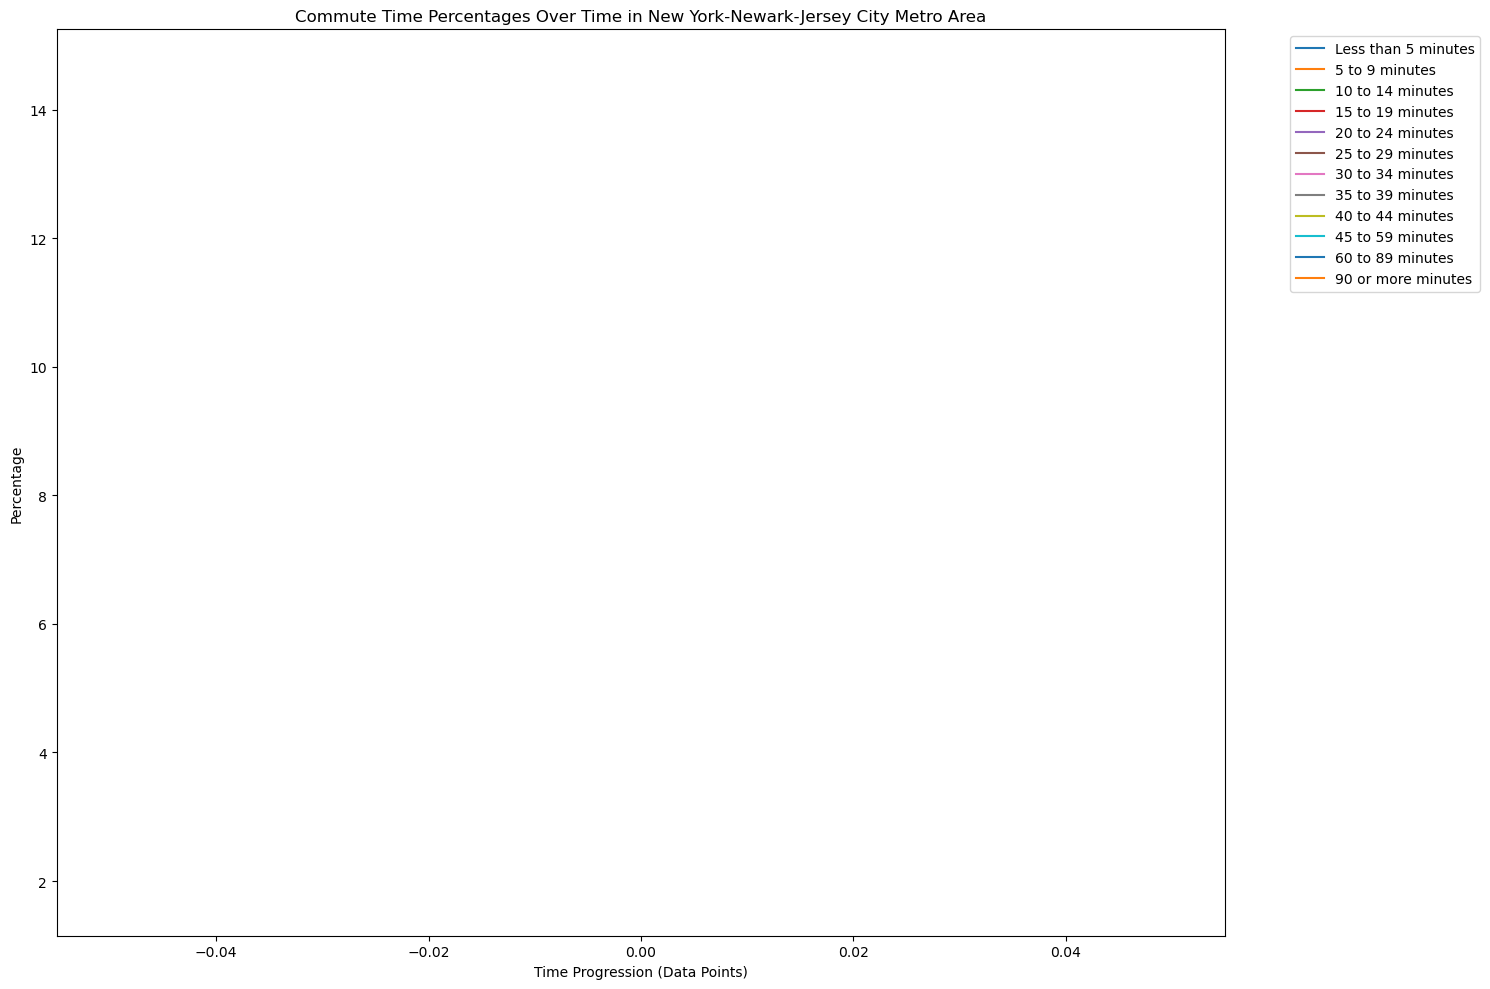

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('Commute_Time_By_Top_25_Metro_Area_All_Years_Percentage.csv')

# Filter for New York-Newark-Jersey City metro area
nyc_data = df[df['Metro Area'] == 'New York-Newark-Jersey City, NY-NJ Metro Area']

# Reset index to use as a proxy for time progression
nyc_data = nyc_data.reset_index(drop=True)

# List of commute time ranges (excluding 'Total')
time_ranges = [
    "Less than 5 minutes", "5 to 9 minutes", "10 to 14 minutes", 
    "15 to 19 minutes", "20 to 24 minutes", "25 to 29 minutes", 
    "30 to 34 minutes", "35 to 39 minutes", "40 to 44 minutes", 
    "45 to 59 minutes", "60 to 89 minutes", "90 or more minutes"
]

# Create the line plot
plt.figure(figsize=(15, 10))

for time_range in time_ranges:
    column_name = f"{time_range} (%)"
    plt.plot(nyc_data.index, nyc_data[column_name], label=time_range)

plt.title("Commute Time Percentages Over Time in New York-Newark-Jersey City Metro Area")
plt.xlabel("Time Progression (Data Points)")
plt.ylabel("Percentage")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig('NYC_Commute_Time_Percentages.png')
print("Graph has been saved as 'NYC_Commute_Time_Percentages.png'")

# Display some statistics
print("\nTrend Analysis:")
for time_range in time_ranges:
    column_name = f"{time_range} (%)"
    start_value = nyc_data[column_name].iloc[0]
    end_value = nyc_data[column_name].iloc[-1]
    change = end_value - start_value
    print(f"{time_range}: {'Increased' if change > 0 else 'Decreased'} by {abs(change):.2f} percentage points")